# Transfer learning
---
In this module, we will
 - analyze resnet nerural network architecture
 - make predictions over random images with resnet pretrained on ImageNet dataset (***http://www.image-net.org/***)
 - create your own dataset
 - finetune resnet for our custom dataset


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## introduction to Resnet18

### Architecture
PyTorch tooling related to image processing can be found in `torchvision` module. Information about accessible pretrained models for PyTorch can be found at ***https://pytorch.org/docs/stable/torchvision/models.html***.

In [2]:
from torchvision import models

In [3]:
resnet18 = models.resnet18()
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [4]:
conv1 = resnet18.layer4[0].conv1
conv1

Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

### Prediction with pretrained model

In [5]:
from image_processing_workshop.utils import get_image_from_url
from image_processing_workshop.visual import plot_image
from torchvision import datasets, transforms
import numpy as np
import os
import torch

In [6]:
# Default path where to save pretrained models.
os.environ["TORCH_HOME"] = "./"

In [7]:
models.resnet.model_urls

{'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
 'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
 'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
 'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
 'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth'}

In [8]:
resnet18 = models.resnet18(pretrained=True)
info = resnet18.eval()

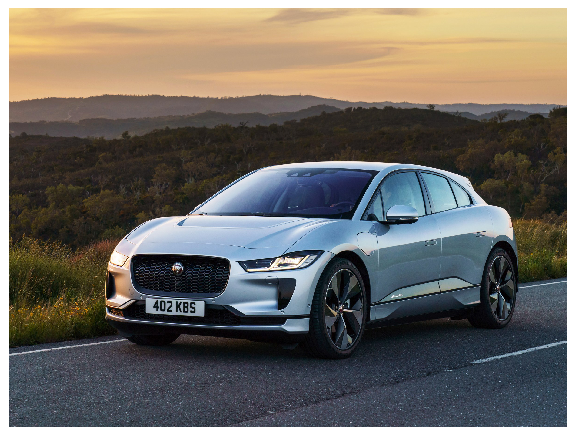

In [9]:
url = 'https://media.wired.com/photos/5b86fce8900cb57bbfd1e7ee/master/pass/Jaguar_I-PACE_S_Indus-Silver_065.jpg'
img = get_image_from_url(url)
plot_image(img)

In [10]:
# Transformation for resnet, normalization is important!!
transformation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [11]:
transformed_img = transformation(img)

In [12]:
img.shape, transformed_img.shape

((1800, 2400, 3), torch.Size([3, 224, 298]))

In [13]:
batch = transformed_img.unsqueeze(0)
resnet18(batch)[0][:10]

tensor([-1.0964, -2.3460, -0.1128, -1.9760, -1.0110, -1.7371, -1.0038, -0.4055,
        -0.7152,  0.5701], grad_fn=<SliceBackward>)

In [14]:
# Let's adjust last layer and add softmax, softmax doesn't need training, it's just normalization.
resnet18.fc = torch.nn.Sequential(
    resnet18.fc, 
    torch.nn.Softmax(dim=1))

In [15]:
resnet18(batch)[0][:10]

tensor([1.1077e-05, 3.1749e-06, 2.9622e-05, 4.5964e-06, 1.2065e-05, 5.8367e-06,
        1.2152e-05, 2.2105e-05, 1.6217e-05, 5.8641e-05],
       grad_fn=<SliceBackward>)

In [16]:
from image_processing_workshop.utils import get_imagenet_category_names
from image_processing_workshop.visual import plot_classify

In [17]:
get_imagenet_category_names(use_cache=True)[:10]

['tench',
 'goldfish',
 'great_white_shark',
 'tiger_shark',
 'hammerhead',
 'electric_ray',
 'stingray',
 'cock',
 'hen',
 'ostrich']

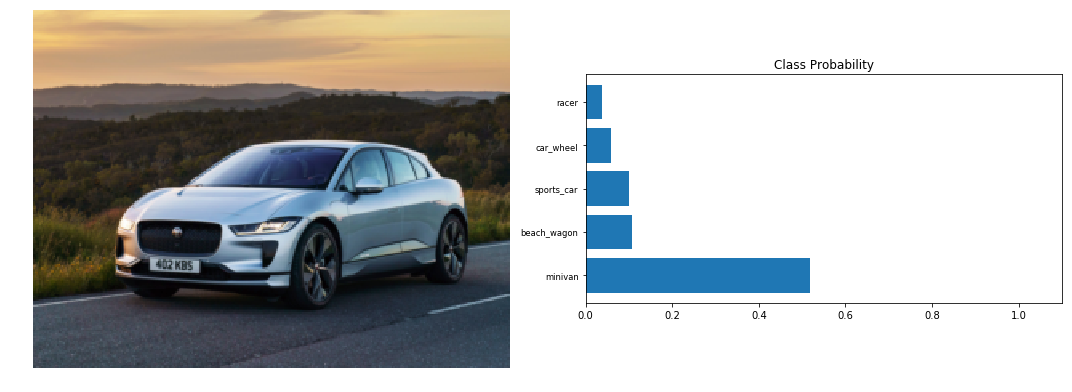

In [18]:
plot_classify(transformed_img, resnet18, topn=5, category_names=get_imagenet_category_names(), figsize=(15,15))

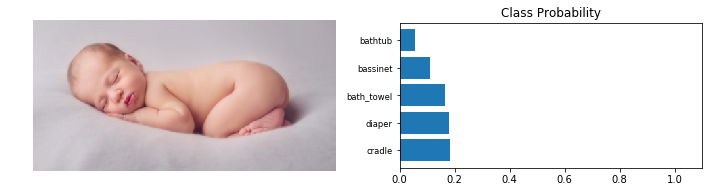

In [19]:
url = 'https://media2.s-nbcnews.com/i/newscms/2019_03/1402031/baby-name-today-main-190115_92c502d95f67cf1f7edc6851782a74c8.jpg'
img = get_image_from_url(url)
transformed_img = transformation(img)
plot_classify(transformed_img, resnet18, topn=5, category_names=get_imagenet_category_names())

## Building of our dataset
Let's Google a few (2-4) image categories (different celebrities, few animal species, different cars, flowers etc..) and build dataset.

### 1. Scrape image url
 - go to Google images https://www.google.com/imghp?hl=EN
 - search image category and scroll a bit through it
 - run console `Ctrl-Shift-J`
 - paste javascript snippet to console  

```javascript
javascript:document.body.innerHTML = `<a href="data:text/csv;charset=utf-8,${escape(Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou).join('\n'))}" download="urls.txt">download urls</a>`;
```

 - rename `urls.txt` in `download="urls.txt"` according to category you scrape e.g. `cats.txt`
 - download image urls
 - copy `cats.txt` to docker shared folder with this ipython notebook

### 2. Download images to proper folder hierarchy
 - run `scrape_urls` with url file and appropriate category name
 - each run of `scrape_urls` will create following folder hierarchy
 
`root_folder/train/class_name/*.jpg`   
`root_folder/valid/class_name/*.jpg`

In [31]:
from image_processing_workshop.utils import scrape_urls

In [32]:
root_folder = './dataset'

In [24]:
scrape_urls('dave.txt', category_name='dave')

  2%|▏         | 3/200 [00:01<01:18,  2.50it/s]

HTTP Error 403: Forbidden


  2%|▎         | 5/200 [00:01<00:57,  3.36it/s]

Not valid file: ./dataset/valid/dave/220px-Foo_Fighters_-_Rock_am_Ring_2018-5671_%28cropped%29.jpg


  6%|▌         | 11/200 [00:03<00:52,  3.60it/s]

HTTP Error 403: Forbidden


  8%|▊         | 17/200 [00:05<00:57,  3.17it/s]

HTTP Error 403: Forbidden


 10%|▉         | 19/200 [00:06<00:49,  3.64it/s]

HTTP Error 403: Forbidden


 10%|█         | 21/200 [00:06<00:52,  3.43it/s]

Not valid file: ./dataset/valid/dave/screen-shot-2019-02-13-at-9.jpg


 14%|█▍        | 29/200 [00:09<00:54,  3.13it/s]

HTTP Error 403: Forbidden


 19%|█▉        | 38/200 [00:14<01:19,  2.04it/s]

HTTP Error 403: Forbidden


 20%|██        | 40/200 [00:14<01:03,  2.53it/s]

Not valid file: ./dataset/valid/dave/170px-Dave_Grohl_in_London.jpg


 20%|██        | 41/200 [00:15<00:54,  2.93it/s]

Not valid file: ./dataset/valid/dave/dave-grohl.jpg


 22%|██▏       | 44/200 [00:16<00:49,  3.13it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 22%|██▎       | 45/200 [00:16<00:39,  3.93it/s]

HTTP Error 403: Forbidden


 26%|██▌       | 51/200 [00:19<00:56,  2.62it/s]

HTTP Error 403: Forbidden


 28%|██▊       | 57/200 [00:23<01:34,  1.51it/s]

HTTP Error 403: Forbidden


 31%|███       | 62/200 [00:26<01:04,  2.16it/s]

Not valid file: ./dataset/train/dave/iKwYvxUmHiv9Gm8iD3wMyL-320-80.jpg


 32%|███▎      | 65/200 [00:26<00:37,  3.57it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 36%|███▌      | 72/200 [00:32<01:27,  1.46it/s]

Not valid file: ./dataset/train/dave/5%2520Dave%2520Grohls.jpg
HTTP Error 403: Forbidden


 36%|███▋      | 73/200 [00:32<01:07,  1.88it/s]

HTTP Error 403: Forbidden


 38%|███▊      | 77/200 [00:37<01:34,  1.31it/s]

HTTP Error 403: Forbidden


 41%|████      | 82/200 [00:40<01:21,  1.45it/s]

HTTP Error 403: Forbidden


 42%|████▏     | 84/200 [00:40<01:02,  1.86it/s]

<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:777)>


 43%|████▎     | 86/200 [00:40<00:44,  2.55it/s]

HTTP Error 403: Forbidden


 46%|████▌     | 92/200 [00:44<00:53,  2.00it/s]

Not valid file: ./dataset/valid/dave/Dave-G.jpg
HTTP Error 403: Forbidden


 48%|████▊     | 97/200 [00:46<00:46,  2.19it/s]

HTTP Error 403: Forbidden


 51%|█████     | 102/200 [00:49<00:52,  1.87it/s]

Not valid file: ./dataset/train/dave/davegrohl.jpg


 56%|█████▌    | 112/200 [00:54<00:26,  3.32it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 58%|█████▊    | 117/200 [00:57<00:40,  2.05it/s]

HTTP Error 403: Forbidden


 60%|██████    | 120/200 [01:00<01:02,  1.27it/s]

HTTP Error 403: Forbidden


 61%|██████    | 122/200 [01:01<00:46,  1.68it/s]

HTTP Error 403: Forbidden


 64%|██████▍   | 128/200 [01:03<00:24,  2.97it/s]

HTTP Error 403: Forbidden


 64%|██████▍   | 129/200 [01:03<00:21,  3.31it/s]

HTTP Error 403: Forbidden


 65%|██████▌   | 130/200 [01:03<00:24,  2.84it/s]

HTTP Error 403: Forbidden


 67%|██████▋   | 134/200 [01:04<00:15,  4.28it/s]

HTTP Error 403: Forbidden


 70%|██████▉   | 139/200 [01:08<00:36,  1.66it/s]

HTTP Error 403: Forbidden


 70%|███████   | 141/200 [01:09<00:33,  1.78it/s]

HTTP Error 403: Forbidden


 71%|███████   | 142/200 [01:10<00:31,  1.84it/s]

Not valid file: ./dataset/valid/dave/foo-fighters-beck-1024x576.jpg


 72%|███████▏  | 144/200 [01:14<01:15,  1.36s/it]

Not valid file: ./dataset/train/dave/Screen-Shot-2013-11-05-at-1.jpg


 75%|███████▌  | 150/200 [01:17<00:40,  1.24it/s]

Not valid file: ./dataset/valid/dave/MV5BYzFiMTJjMzYtNGJhMS00NmVjLWI1Y2UtNzE4ZDRkMTYxYzlhXkEyXkFqcGdeQXVyMTU3NTQyMTg@.jpg


 76%|███████▌  | 152/200 [01:17<00:23,  2.06it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 78%|███████▊  | 156/200 [01:21<00:37,  1.17it/s]

HTTP Error 403: Forbidden


 80%|████████  | 160/200 [01:24<00:32,  1.24it/s]

HTTP Error 403: Forbidden


 82%|████████▏ | 164/200 [01:28<00:45,  1.25s/it]

Not valid file: ./dataset/train/dave/dave-grohl.jpg


 85%|████████▌ | 170/200 [01:31<00:17,  1.67it/s]

Not valid file: ./dataset/train/dave/220px-Foo_Fighters_Tenacious_D_concert_in_2011.jpg
HTTP Error 403: Forbidden


 86%|████████▋ | 173/200 [01:32<00:11,  2.41it/s]

Not valid file: ./dataset/train/dave/dave-grohl-and-corey-taylor.jpg


 90%|████████▉ | 179/200 [01:38<00:22,  1.07s/it]

HTTP Error 403: Forbidden


 90%|█████████ | 181/200 [01:41<00:23,  1.24s/it]

HTTP Error 403: Forbidden


 92%|█████████▎| 185/200 [01:43<00:08,  1.70it/s]

HTTP Error 403: Forbidden


 99%|█████████▉| 198/200 [01:52<00:00,  3.12it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


100%|██████████| 200/200 [01:52<00:00,  3.68it/s]

Failed 56
Succ 144


('./dataset/train/dave', './dataset/valid/dave')

In [25]:
scrape_urls('v518.txt', category_name='vladimir518')

  1%|          | 1/100 [00:00<00:16,  6.07it/s]

Not valid file: ./dataset/train/vladimir518/220px-Vladimir_518_2013.jpg


  5%|▌         | 5/100 [00:01<00:21,  4.45it/s]

HTTP Error 403: Forbidden


  9%|▉         | 9/100 [00:02<00:25,  3.64it/s]

Not valid file: ./dataset/train/vladimir518/A-2649897-1401371529-8296.jpg


 13%|█▎        | 13/100 [00:04<00:28,  3.02it/s]

Not valid file: ./dataset/valid/vladimir518/1220x365c-4e26-vladimir-518.jpg


 21%|██        | 21/100 [00:05<00:13,  5.86it/s]

HTTP Error 403: Forbidden


 23%|██▎       | 23/100 [00:08<01:15,  1.02it/s]

Not valid file: ./dataset/valid/vladimir518/VLADIMIR-518_web_event.jpg


 25%|██▌       | 25/100 [00:09<00:53,  1.40it/s]

Not valid file: ./dataset/train/vladimir518/af57371c.jpg


 28%|██▊       | 28/100 [00:11<01:02,  1.15it/s]

HTTP Error 404: Not Found


 52%|█████▏    | 52/100 [00:30<02:42,  3.39s/it]

Not valid file: ./dataset/valid/vladimir518/?media_id=10154276835910870.jpg


 55%|█████▌    | 55/100 [00:31<00:59,  1.32s/it]

HTTP Error 403: Forbidden


 60%|██████    | 60/100 [00:34<00:25,  1.60it/s]

Not valid file: ./dataset/train/vladimir518/Vladimir-518-ctverec.jpg


 65%|██████▌   | 65/100 [00:35<00:07,  4.63it/s]

HTTP Error 403: Forbidden


 68%|██████▊   | 68/100 [00:36<00:09,  3.40it/s]

Not valid file: ./dataset/train/vladimir518/M732881-1de2b.jpg


 72%|███████▏  | 72/100 [00:36<00:06,  4.22it/s]

HTTP Error 403: Forbidden


 76%|███████▌  | 76/100 [00:48<01:20,  3.35s/it]

Not valid file: ./dataset/valid/vladimir518/?media_id=10155940007130870.jpg


 80%|████████  | 80/100 [00:48<00:24,  1.24s/it]

Not valid file: ./dataset/valid/vladimir518/9wpeV.jpg


 83%|████████▎ | 83/100 [00:49<00:10,  1.59it/s]

HTTP Error 403: Forbidden


 85%|████████▌ | 85/100 [00:50<00:06,  2.45it/s]

HTTP Error 403: Forbidden


 87%|████████▋ | 87/100 [00:50<00:04,  2.72it/s]

Not valid file: ./dataset/train/vladimir518/260?_sig=4m77qhoIYG3RBMO93uL9jNydGoc_9zaCsIXzKU6hKzU.jpg


 93%|█████████▎| 93/100 [01:05<00:25,  3.65s/it]

Not valid file: ./dataset/valid/vladimir518/?media_id=53090765869.jpg


 99%|█████████▉| 99/100 [01:08<00:00,  1.39it/s]

HTTP Error 403: Forbidden


100%|██████████| 100/100 [01:09<00:00,  1.34it/s]

Failed 21
Succ 79


('./dataset/train/vladimir518', './dataset/valid/vladimir518')

In [33]:
scrape_urls('zeman.txt', category_name='zeman')


  5%|▌         | 5/100 [00:01<00:28,  3.39it/s]

HTTP Error 403: Forbidden



  7%|▋         | 7/100 [00:01<00:18,  4.94it/s]

HTTP Error 403: Forbidden



 17%|█▋        | 17/100 [00:04<00:16,  5.05it/s]

HTTP Error 403: Forbidden



 23%|██▎       | 23/100 [00:05<00:15,  5.12it/s]

HTTP Error 403: Forbidden



 36%|███▌      | 36/100 [00:11<00:27,  2.31it/s]


HTTP Error 403: Forbidden


 40%|████      | 40/100 [00:13<00:23,  2.60it/s]

Not valid file: ./dataset/train/zeman/Zeman-vlajka-EU-Hrad-na-%C5%A1%C3%AD%C5%99ku-detail-03-04-2013-e1515510234772.jpg



 45%|████▌     | 45/100 [00:15<00:31,  1.75it/s]

HTTP Error 403: Forbidden



 47%|████▋     | 47/100 [00:16<00:18,  2.86it/s]

HTTP Error 403: Forbidden
Not valid file: ./dataset/train/zeman/xaQp9.jpg



 52%|█████▏    | 52/100 [00:27<00:44,  1.07it/s]

HTTP Error 403: Forbidden



 54%|█████▍    | 54/100 [00:27<00:25,  1.79it/s]

Not valid file: ./dataset/train/zeman/5714497_soud-statni-zastupce-benesova-pavel-zeman-ministryne-v2.jpg



 60%|██████    | 60/100 [00:29<00:08,  4.54it/s]

Not valid file: ./dataset/valid/zeman/gpPBPE.jpg
HTTP Error 403: Forbidden



 61%|██████    | 61/100 [00:40<02:14,  3.44s/it]

Not valid file: ./dataset/valid/zeman/?media_id=1729095767156229.jpg



 71%|███████   | 71/100 [00:43<00:09,  3.10it/s]

Not valid file: ./dataset/valid/zeman/zeman.jpg



 84%|████████▍ | 84/100 [01:00<00:54,  3.43s/it]

Not valid file: ./dataset/train/zeman/?media_id=18812970835.jpg



 85%|████████▌ | 85/100 [01:00<00:37,  2.48s/it]

Not valid file: ./dataset/train/zeman/orban-zeman.jpg



 93%|█████████▎| 93/100 [01:03<00:02,  2.77it/s]

HTTP Error 403: Forbidden



 99%|█████████▉| 99/100 [01:06<00:00,  2.48it/s]

Not valid file: ./dataset/train/zeman/2725.jpg



100%|██████████| 100/100 [01:06<00:00,  2.55it/s]

Failed 19
Succ 81


('./dataset/train/zeman', './dataset/valid/zeman')

In [34]:
scrape_urls('babis.txt', category_name='babis')


  7%|▋         | 14/200 [00:04<00:52,  3.53it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden



 11%|█         | 22/200 [00:11<02:08,  1.38it/s]

HTTP Error 403: Forbidden



 14%|█▍        | 29/200 [00:13<01:00,  2.84it/s]

HTTP Error 403: Forbidden



 22%|██▏       | 44/200 [00:31<01:07,  2.31it/s]

Not valid file: ./dataset/train/babis/220px-Katarzyna_Babis_2017.jpg



 28%|██▊       | 56/200 [00:36<00:46,  3.11it/s]

Not valid file: ./dataset/valid/babis/3500.jpg



 32%|███▏      | 64/200 [00:40<01:03,  2.14it/s]

Not valid file: ./dataset/train/babis/tenor.jpg
HTTP Error 403: Forbidden



 37%|███▋      | 74/200 [00:46<00:54,  2.33it/s]

HTTP Error 403: Forbidden



 39%|███▉      | 78/200 [00:49<01:49,  1.12it/s]

HTTP Error 403: Forbidden



 40%|███▉      | 79/200 [00:49<01:30,  1.33it/s]

Not valid file: ./dataset/train/babis/1D031F6B-0034-40AF-BA59-6CB1BA2C546D_w250_r1_s.jpg



 40%|████      | 80/200 [00:50<01:18,  1.52it/s]

HTTP Error 403: Forbidden



 42%|████▏     | 83/200 [00:51<00:44,  2.62it/s]

HTTP Error 403: Forbidden



 49%|████▉     | 98/200 [00:56<00:33,  3.03it/s]

HTTP Error 403: Forbidden



 52%|█████▏    | 103/200 [01:00<00:58,  1.67it/s]

Not valid file: ./dataset/train/babis/Andrej_Babis-386x218.jpg



 54%|█████▍    | 108/200 [01:03<01:07,  1.36it/s]

HTTP Error 403: Forbidden



 55%|█████▌    | 110/200 [01:05<01:21,  1.11it/s]

HTTP Error 403: Forbidden



 62%|██████▏   | 123/200 [01:13<00:32,  2.40it/s]

HTTP Error 403: Forbidden



 64%|██████▍   | 128/200 [01:15<00:39,  1.81it/s]

Not valid file: ./dataset/valid/babis/Andrej-Babis-200x150.jpg



 65%|██████▌   | 130/200 [01:19<01:24,  1.20s/it]

<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:777)>



 67%|██████▋   | 134/200 [01:21<00:37,  1.76it/s]

HTTP Error 403: Forbidden



 74%|███████▎  | 147/200 [01:27<00:20,  2.60it/s]

HTTP Error 403: Forbidden



 74%|███████▍  | 149/200 [01:28<00:25,  2.00it/s]

[Errno 36] File name too long: './dataset/valid/babis/kosmonosy-czech-republic-18th-mar-2019-czech-prime-minister-andrej-babis-attends-the-colloquium-ii-assessment-of-strategic-cooperation-with-government-and-new-challenges-working-meeting-of-leading-representatives-of-car-industry-academics-government-members-and-other-guests-organised-by-automotive-industry-association-on-march-18-2019-in-kosmonosy-czech-republic-credit-radek-petrasekctk-photoalamy-live-news-T07EXD.jpg'
Not valid file: ./dataset/valid/babis/880x495_395701.jpg



 76%|███████▌  | 152/200 [01:30<00:30,  1.56it/s]

Not valid file: ./dataset/valid/babis/Andrej-Babis.jpg



 78%|███████▊  | 156/200 [01:32<00:18,  2.32it/s]

HTTP Error 403: Forbidden



 78%|███████▊  | 157/200 [01:32<00:15,  2.75it/s]

Not valid file: ./dataset/train/babis/Babis-Andrej_188.jpg



 80%|███████▉  | 159/200 [01:32<00:12,  3.19it/s]

HTTP Error 403: Forbidden



 81%|████████  | 162/200 [01:34<00:13,  2.72it/s]

Not valid file: ./dataset/train/babis/andrej_babis_5_181114-194727_mda.jpg
HTTP Error 403: Forbidden



 86%|████████▌ | 172/200 [01:39<00:11,  2.39it/s]

Not valid file: ./dataset/valid/babis/i6150.jpg



 86%|████████▋ | 173/200 [01:39<00:11,  2.29it/s]

HTTP Error 403: Forbidden



 88%|████████▊ | 176/200 [01:40<00:08,  2.75it/s]

HTTP Error 403: Forbidden



 89%|████████▉ | 178/200 [01:42<00:12,  1.78it/s]

<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:777)>



 90%|█████████ | 181/200 [01:43<00:07,  2.40it/s]

Not valid file: ./dataset/train/babis/5622163702001.jpg



 92%|█████████▏| 183/200 [01:45<00:12,  1.39it/s]

HTTP Error 403: Forbidden



 92%|█████████▎| 185/200 [01:46<00:10,  1.47it/s]

<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:777)>



 98%|█████████▊| 195/200 [01:52<00:02,  2.35it/s]

HTTP Error 403: Forbidden



100%|██████████| 200/200 [01:58<00:00,  1.52it/s]

Failed 38
Succ 162


('./dataset/train/babis', './dataset/valid/babis')

### 3. First look at data

In [35]:
from torchvision import datasets, transforms, utils
from image_processing_workshop.visual import plot_image

In [36]:
# Lets visualize download images.
transformation = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor()])
dataset = datasets.ImageFolder(os.path.join(root_folder, 'valid'), transformation)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

In [37]:
images, labels = next(iter(loader))

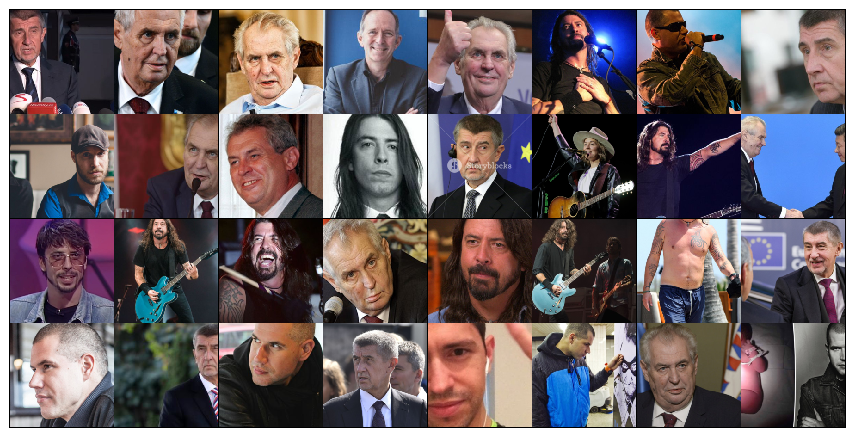

In [38]:
image_grid = utils.make_grid(images)
plot_image(image_grid, figsize=(15,15))

### 4. Prepare training dataset

In [39]:
transformation = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [40]:
dataset = {x: datasets.ImageFolder(os.path.join(root_folder, x), transformation[x]) for x in ['train', 'valid']}
loader = {x: torch.utils.data.DataLoader(dataset[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'valid']}

dataset_size = {x: len(dataset[x]) for x in ['train', 'valid']}
class_names = dataset['train'].classes

In [41]:
dataset_size

{'train': 224, 'valid': 219}

In [42]:
class_names

['babis', 'dave', 'vladimir518', 'zeman']

### 5. Classify with original renset

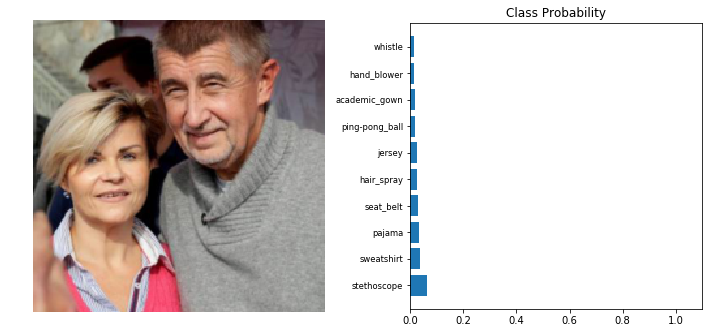

In [47]:
plot_classify(dataset['valid'][4][0], resnet18, topn=10, category_names=get_imagenet_category_names())

## Finetune resnet
We will use pretrained model on top of which we will place small classification feed forward network. Then we will train this whole architecture in 2 steps:   

1) fix of Resnet pretrained weights and tain just our simple added classifier     
2) use smaller learning rate and adjust also top layers of Resnet


### Setup model

In [81]:
from torch import nn, optim

In [82]:
output_size = len(dataset['train'].classes)
output_size

4

In [83]:
resnet18 = models.resnet18(pretrained=True)

In [84]:
resnet18.fc = torch.nn.Sequential(
    torch.nn.Linear(512, output_size),
    torch.nn.Softmax(dim=1))

loss_fce = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.fc.parameters())

### Basic finetuning of last layers

In [85]:
for param in resnet18.parameters():
    param.requires_grad = False

In [86]:
for param in resnet18.fc.parameters():
    param.requires_grad = True

In [87]:
model = resnet18

In [88]:
def get_valid_acc_and_loss(model, loss_fce, valid_loader):
    accuracy = 0
    loss = 0
    was_training = model.training
    model.eval()
    
    for images, labels in valid_loader:
        predictions = model(images)
        accuracy += (predictions.argmax(dim=1) == labels).type(torch.FloatTensor).mean().item() 
        loss += loss_fce(predictions, labels).item()
    
    model.train(mode=was_training)
    return accuracy / len(valid_loader) * 100, loss / len(valid_loader)

In [89]:
from collections import deque

# Initial params setup.
epochs = 20
report_period = 3
batch_iteration = 0

# Storing of some data.
train_leak_loss = deque(maxlen=report_period)
train_loss_history = []
valid_loss_history = []
valid_acc_history = []

In [97]:
for epoch in range(epochs):
    # Setup net to train mode and go through one epoch.
    model.train()
    for images, labels in loader['train']:
        batch_iteration += 1
        
        # Training net on one batch.
        optimizer.zero_grad()
        predictions = model.forward(images)
        loss = loss_fce(predictions, labels)
        loss.backward()
        optimizer.step()
        
        train_leak_loss.append(loss.item())
        # In case we should report, lets make validation on valid set.
        if batch_iteration % report_period == 0:
            model.eval()
            # We don't want to collect info for gradients from here.
            with torch.no_grad():
                valid_accuracy, valid_loss = get_valid_acc_and_loss(model, loss_fce, loader['valid'])
                
            print(f'Epoch: {epoch+1}/{epochs}.. ',
                  f"Train Loss: {round(np.mean(train_leak_loss), 2)}.. ",
                  f"Valid Loss: {round(valid_loss, 2)}.. ",
                  f"Valid Acc: {round(valid_accuracy, 2)}%")
            
            train_loss_history.append(np.mean(train_leak_loss))
            valid_loss_history.append(valid_loss)
            valid_acc_history.append(valid_accuracy)
                        
            model.train()

Epoch: 1/5..  Train Loss: 1.1..  Valid Loss: 1.05..  Valid Acc: 73.33%
Epoch: 1/5..  Train Loss: 1.08..  Valid Loss: 1.04..  Valid Acc: 73.64%
Epoch: 1/5..  Train Loss: 1.0..  Valid Loss: 1.03..  Valid Acc: 73.41%
Epoch: 2/5..  Train Loss: 1.06..  Valid Loss: 1.02..  Valid Acc: 72.44%
Epoch: 2/5..  Train Loss: 1.01..  Valid Loss: 1.02..  Valid Acc: 72.92%
Epoch: 3/5..  Train Loss: 1.0..  Valid Loss: 1.01..  Valid Acc: 75.76%
Epoch: 3/5..  Train Loss: 0.97..  Valid Loss: 1.01..  Valid Acc: 74.7%
Epoch: 4/5..  Train Loss: 1.03..  Valid Loss: 1.01..  Valid Acc: 74.87%
Epoch: 4/5..  Train Loss: 0.98..  Valid Loss: 1.02..  Valid Acc: 74.14%
Epoch: 4/5..  Train Loss: 0.95..  Valid Loss: 1.02..  Valid Acc: 73.97%
Epoch: 5/5..  Train Loss: 0.93..  Valid Loss: 1.01..  Valid Acc: 73.97%
Epoch: 5/5..  Train Loss: 0.98..  Valid Loss: 1.01..  Valid Acc: 74.06%


### Extra finetuning of resnet layer4
Nice reading about advanced strategies for setup of lr here: ***https://www.jeremyjordan.me/nn-learning-rate/***

 - let's setup as trainable parameters of last layer of resnet model
 - make learning rate 10 times smaller

In [91]:
optimizer.param_groups[0]['lr']

0.001

In [92]:
optimizer.param_groups[0]['params']

[Parameter containing:
 tensor([[-1.8282e-02,  2.0661e-02,  1.7268e-02,  ..., -1.5663e-02,
           4.5955e-03, -1.9029e-02],
         [ 3.2847e-02,  7.6786e-03, -1.6063e-02,  ...,  2.8991e-02,
          -2.4288e-02,  4.9443e-02],
         [-3.8288e-02,  3.1429e-02,  4.9583e-02,  ..., -1.6662e-02,
           5.2354e-03, -6.3178e-03],
         [-4.6915e-02,  1.4437e-02, -1.6037e-02,  ...,  3.2063e-02,
           4.7190e-06,  1.6785e-02]], requires_grad=True),
 Parameter containing:
 tensor([ 0.0441, -0.0142, -0.0375,  0.0294], requires_grad=True)]

In [93]:
epochs=5

In [94]:
for param in model.layer4.parameters():
    param.requires_grad = True

In [95]:
optimizer.param_groups[0]['params'] = optimizer.param_groups[0]['params'] + list(model.layer4.parameters())

In [96]:
optimizer.param_groups[0]['lr'] = 0.0001

### Visualize progress of training

In [98]:
import matplotlib.pylab as plt 

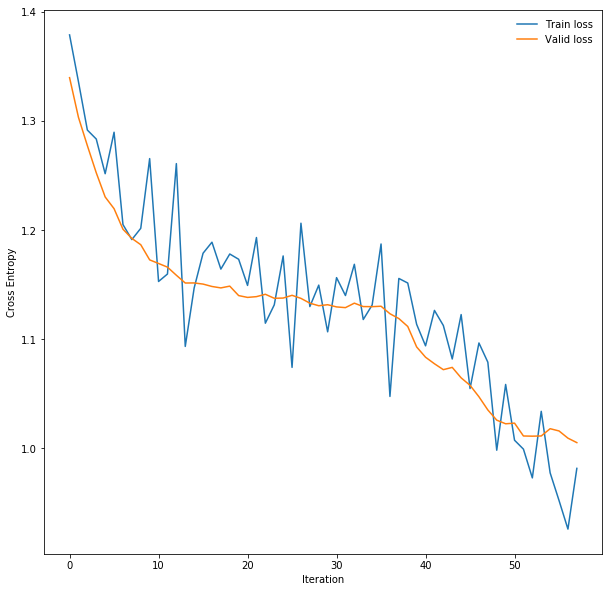

In [99]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.set_xlabel('Iteration')
ax.set_ylabel('Cross Entropy')
plt.plot(train_loss_history, label='Train loss')
plt.plot(valid_loss_history, label='Valid loss')
plt.legend(frameon=False)

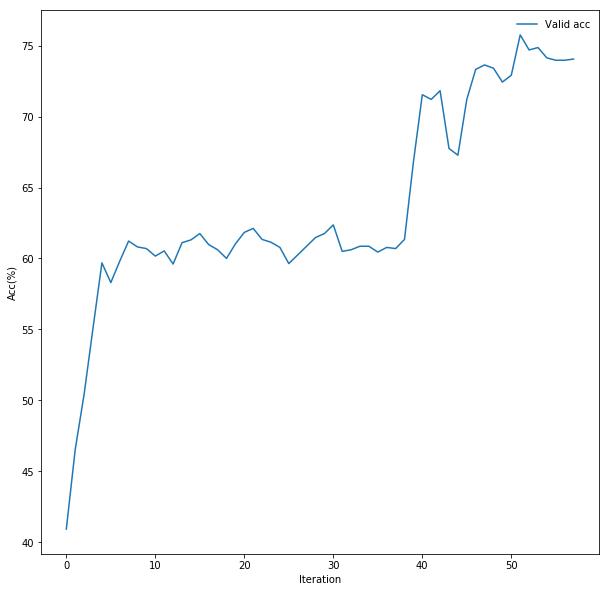

In [100]:
fig = plt.figure(figsize=(10, 10))
plt.plot(valid_acc_history, label='Valid acc')
ax = plt.gca()
ax.set_xlabel('Iteration')
ax.set_ylabel('Acc(%)')
plt.legend(frameon=False)

## Results evaluation

In [101]:
info = model.eval()

### View single images and predictions

In [102]:
from image_processing_workshop.visual import plot_classify, plot_image

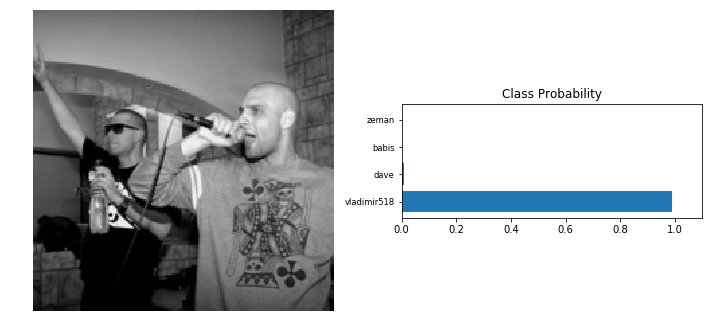

In [109]:
plot_classify(dataset['valid'][157][0], model, category_names=class_names)

### Load reuslts to pandas df

In [110]:
from image_processing_workshop.eval import get_results_df
from image_processing_workshop.visual import plot_df_examples

In [111]:
df = get_results_df(model, loader['valid'])
df.head(10)

label_class_name  label_class_score predicted_class_name_top1  \
0            zeman           0.001693                     babis   
1            zeman           0.000213               vladimir518   
2             dave           0.998442                      dave   
3            zeman           0.004967                     babis   
4             dave           0.999070                      dave   
5            zeman           0.001700                     babis   
6      vladimir518           0.982490               vladimir518   
7             dave           0.982808                      dave   
8             dave           0.999477                      dave   
9            babis           0.002942               vladimir518   

   predicted_class_score_top1  \
0                    0.947200   
1                    0.573600   
2                    0.998442   
3                    0.834372   
4                    0.999070   
5                    0.833972   
6                    0.982490   
7                    0.982808   
8                    0.999477   
9                    0.942056   

                                               image  
0  [[[0.005565485917031765, -0.11430778354406357,...  
1  [[[1.1357992887496948, 1.1357992887496948, 1.1...  
2  [[[-1.467163324356079, -1.4500386714935303, -1...  
3  [[[0.45080918073654175, 0.2795616686344147, 0....  
4  [[[1.9920369386672974, 1.9920369386672974, 1.9...  
5  [[[-1.1417930126190186, -1.1075435876846313, -...  
6  [[[-1.3472901582717896, -1.3130406141281128, -...  
7  [[[1.4954191446304321, 1.4954191446304321, 1.4...  
8  [[[-1.1246683597564697, -1.158917784690857, -1...  
9  [[[1.18717360496521, 1.2385478019714355, 1.272...

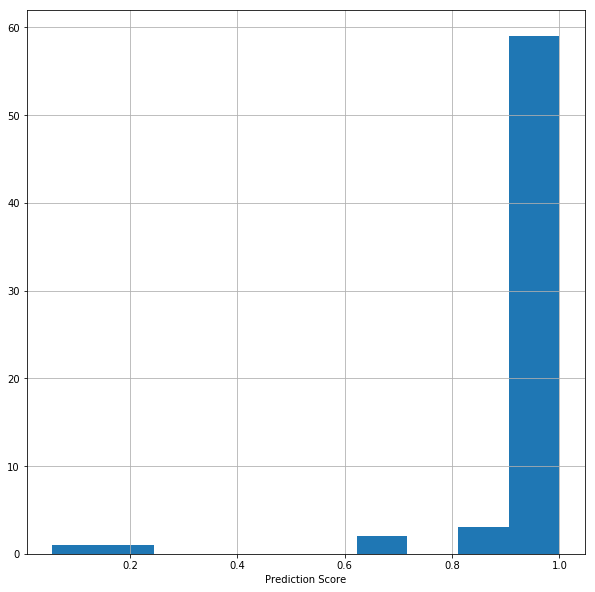

In [112]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.set_xlabel('Prediction Score')
df[df.label_class_name=='dave'].label_class_score.hist(ax=ax)

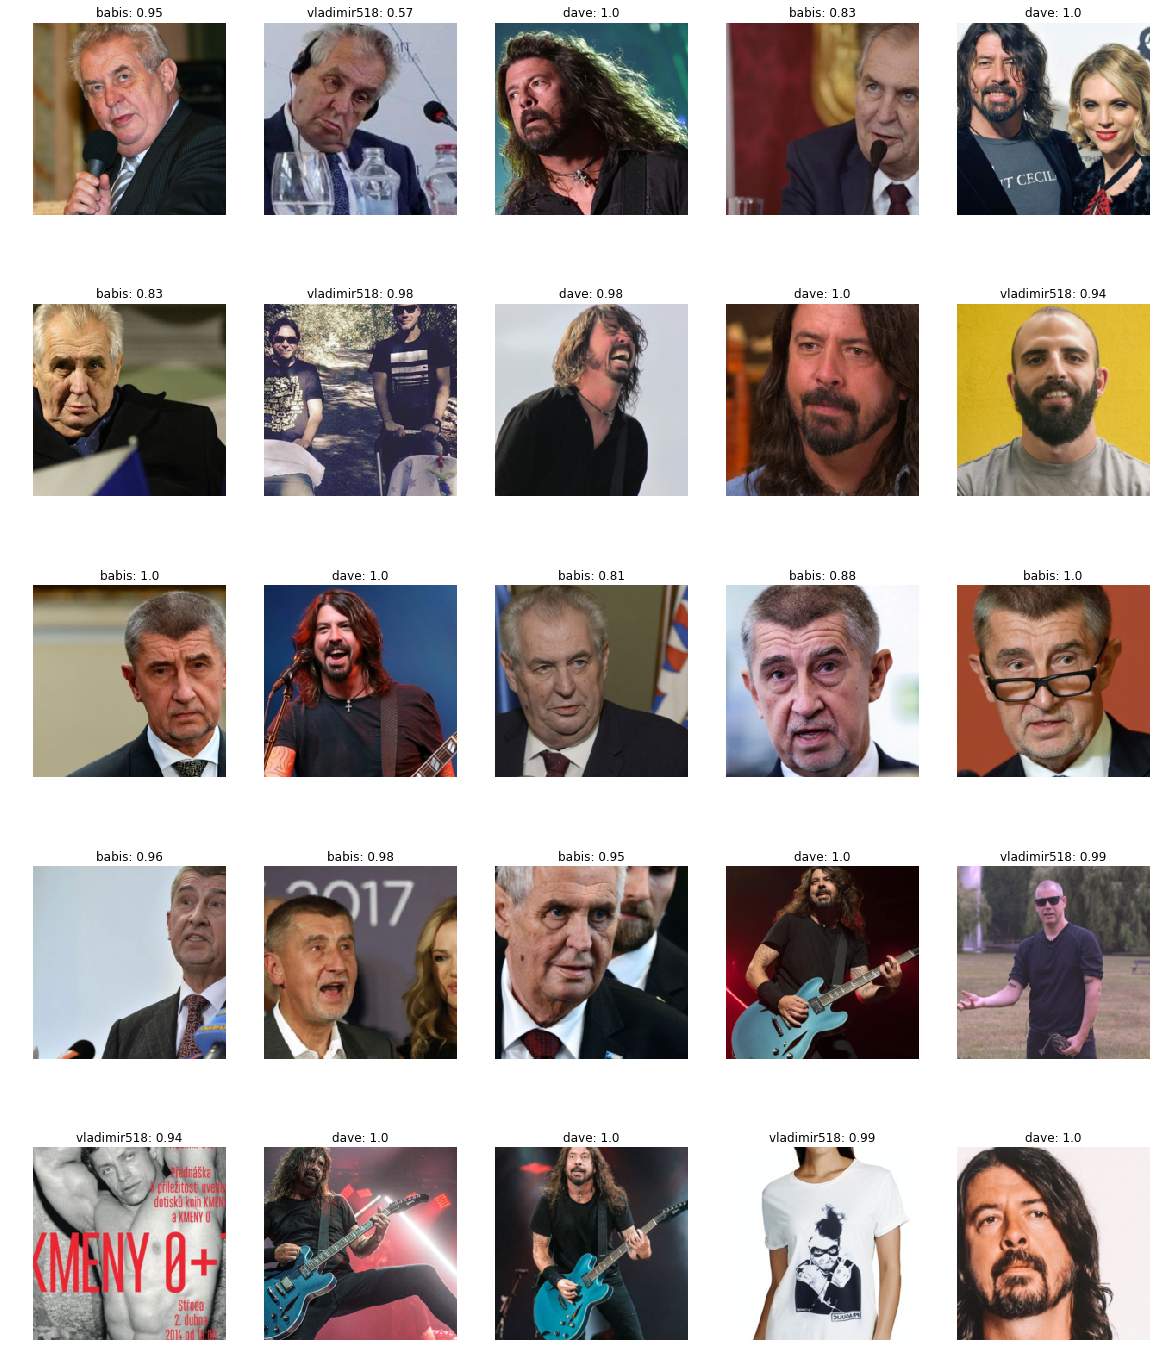

In [113]:
plot_df_examples(df.iloc[:25])

### Overall Recall and Precision


In [114]:
from image_processing_workshop.eval import get_rec_prec

In [115]:
get_rec_prec(df, class_names)

class_name  recall  precision
0        babis   80.26      66.30
1         dave   96.97      85.33
2  vladimir518   94.87      71.15
3        zeman    0.00       0.00

### Accuracy

In [116]:
from image_processing_workshop.eval import get_accuracy

In [117]:
get_accuracy(df)

73.97

### False Positives

In [118]:
from image_processing_workshop.eval import get_false_positives

In [119]:
fp = get_false_positives(df, label_class_name='dave')

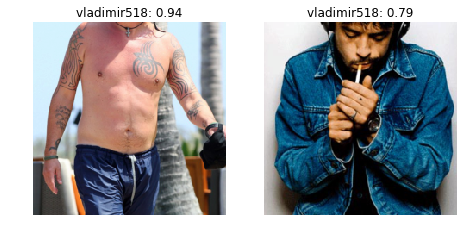

In [120]:
plot_df_examples(fp)

### Confusion Matrix

In [121]:
from image_processing_workshop.visual import plot_coocurance_matrix

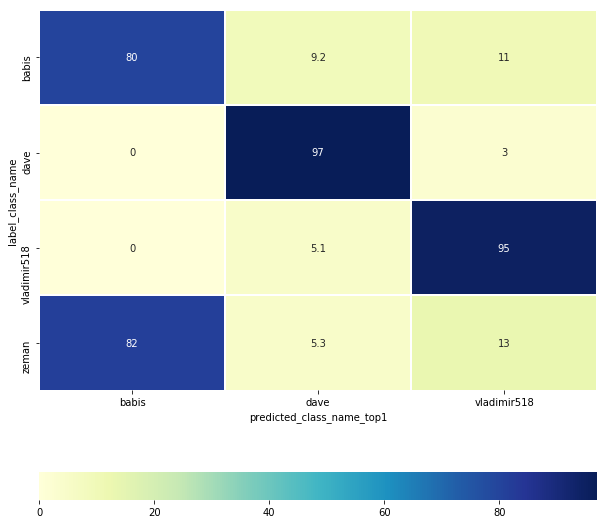

In [122]:
plot_coocurance_matrix(df, use_log=False)